## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import csv
import os
from scipy.stats import linregress
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from parse_preprocessed_data import get_inputs_and_targets
from LSTM_Model import LSTMModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyper-Parameters

In [2]:
#These hyper-paramters are identical to the Github's to test differences
seq_length = 200

hidden_size = 512
learning_rate = 2e-3
dropout = 0.5
batch_size = 100
num_layers = 3
max_epochs = 20
validation_prop = 0.2

snaking = False
pathing = True
column_depth = False

## Load Data

In [3]:
#Not Original
char_to_ix, ix_to_char, vocab_size, inputs, targets = get_inputs_and_targets('data_preprocessed/mario.txt', seq_length, snaking, pathing, column_depth)
vocab_size, inputs.shape, targets.shape

#inputs is (num_sequences, seq_length, vocab_size), and is one-hot encoded
#targets is (num_sequence, seq_length)

Unique chars: ['\n', '-', '<', '>', '?', 'B', 'E', 'Q', 'S', 'X', '[', ']', 'b', 'o', 'x']
Number of unique chars: 15


  0%|          | 0/37 [00:00<?, ?it/s]

(15, (119150, 200, 15), (119150, 200))

In [4]:
#Save the starting seed
first_three_cols = inputs[0][:3 * 17]
np.savetxt('data_preprocessed/seed.txt', first_three_cols)

In [5]:
#Convert the inputs and targets into tensors and load them into a dataset, then DataLoader
inputs_tensor = torch.tensor(inputs)
targets_tensor = torch.tensor(targets)

train_dataset = TensorDataset(inputs_tensor, targets_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Model

In [6]:
#Initialize model
model = LSTMModel(vocab_size, hidden_size, num_layers, dropout).to(device)

In [7]:
#Set the loss and optimizer functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train Model

In [8]:
#Train the model

#Lists to store loss and accuracy values for each epoch
loss_values = []
accuracy_values = []

for epoch in range(max_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0

    #Record the start time of the epoch
    start_time = time.time()

    num_batch_targets = 0
    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        #Clear gradients from previous iteration
        optimizer.zero_grad()
        
        #Forward pass
        outputs, _ = model(batch_inputs)
        
        #Reshape outputs and targets to have the same batch size
        outputs_flat = outputs.view(-1, outputs.size(-1))
        targets_flat = batch_targets.view(-1)
        
        #Calculate loss
        loss = criterion(outputs_flat, targets_flat.long())
        
        #Backward pass/ Compute gradients
        loss.backward()
        
        #Update weights
        optimizer.step()

        #Accumulate loss for the entire batch
        total_loss += loss.item() * batch_inputs.size(0)

        #Calculate accuracy for the batch
        _, predicted = torch.max(outputs, 2)
        correct = (predicted == batch_targets).sum().item()
        total_correct += correct
        num_batch_targets += len(batch_targets) * len(batch_targets[0])
    
    #Calculate average loss and accuracy for the epoch
    epoch_loss = total_loss / len(train_loader.dataset)
    epoch_accuracy = total_correct / num_batch_targets

    #Stor loss and accuracy values to plot later
    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)

    #Calculate the time taken for the epoch
    epoch_time = time.time() - start_time
    
    #Print per-epoch loss and accuracy
    print(f'Epoch [{epoch+1}/{max_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {epoch_time:.2f} seconds')

Epoch [1/20], Loss: 0.2884, Accuracy: 0.9155, Time: 40.56 seconds
Epoch [2/20], Loss: 0.1070, Accuracy: 0.9658, Time: 40.49 seconds
Epoch [3/20], Loss: 0.0808, Accuracy: 0.9734, Time: 40.73 seconds
Epoch [4/20], Loss: 0.0721, Accuracy: 0.9760, Time: 42.42 seconds
Epoch [5/20], Loss: 0.0815, Accuracy: 0.9734, Time: 41.95 seconds
Epoch [6/20], Loss: 0.0658, Accuracy: 0.9780, Time: 42.08 seconds
Epoch [7/20], Loss: 0.0638, Accuracy: 0.9786, Time: 42.75 seconds
Epoch [8/20], Loss: 0.0628, Accuracy: 0.9789, Time: 41.48 seconds
Epoch [9/20], Loss: 0.0617, Accuracy: 0.9792, Time: 40.52 seconds
Epoch [10/20], Loss: 0.0611, Accuracy: 0.9794, Time: 41.07 seconds
Epoch [11/20], Loss: 0.0604, Accuracy: 0.9796, Time: 41.65 seconds
Epoch [12/20], Loss: 0.0607, Accuracy: 0.9795, Time: 40.44 seconds
Epoch [13/20], Loss: 0.0593, Accuracy: 0.9799, Time: 40.23 seconds
Epoch [14/20], Loss: 0.0590, Accuracy: 0.9800, Time: 40.69 seconds
Epoch [15/20], Loss: 0.0594, Accuracy: 0.9799, Time: 40.66 seconds
Epoc

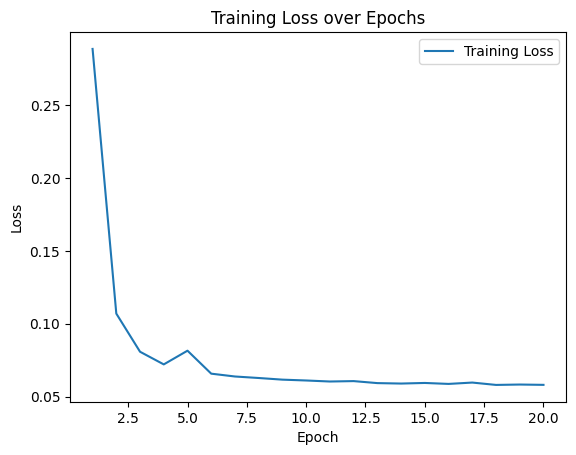

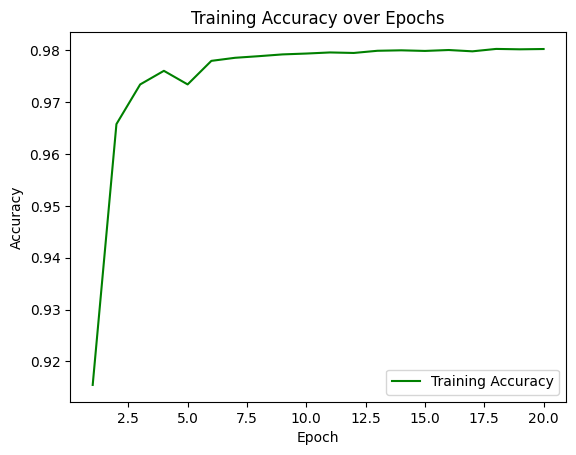

In [9]:
#Plot training loss over epochs
plt.plot(range(1, max_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

#Plot training accuracy over epochs
plt.plot(range(1, max_epochs + 1), accuracy_values, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()

## Generate Levels

In [10]:
#Not Original

#'seed' is a starting one-hot encoded sequence used as the beginning of each level
seed = np.loadtxt('data_preprocessed/seed.txt', dtype=float)[:3*17 - 1].copy()

In [11]:
#Not Original

#Converts the one-hot output of the model into a string
def onehot_to_string(onehot):
    ints = np.argmax(onehot, axis=-1)
    chars = [ix_to_char[ix] for ix in ints]
    string = "".join(chars)
    char_array = []
    for line in string.rstrip().split('\n')[:-1]:
        if len(line) == 16:
            char_array.append(list(line))
        elif len(line) > 16:
            char_array.append(list(line[:16]))
        elif len(line) < 16:
            char_array.append(['-'] * (16 - len(line)) + list(line))
    char_array = np.array(char_array).T
    string = ""
    for row in char_array:
        string += "".join(row) + "\n"
    return string

In [12]:
#Not Original
if pathing:
    seedChar = 'x'
else:
    seedChar = '-'
seed[17+14] = 0
seed[17+14][char_to_ix[seedChar]] = 1
seed[17*2+14] = 0
seed[17*2+14][char_to_ix[seedChar]] = 1
#The seed in its one-hot form
print(seed)
#The seed in its character form
print(onehot_to_string(seed))

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [13]:
#Not Original

#Returns a copy of the seed in its one-hot encoded form
def get_seed():
    seed = np.loadtxt('data_preprocessed/seed.txt', dtype=float)[:3*17 - 1]
    if pathing:
        seedChar = 'x'
    else:
        seedChar = '-'
    seed[17+14] = 0
    seed[17+14][char_to_ix[seedChar]] = 1
    seed[17*2+14] = 0
    seed[17*2+14][char_to_ix[seedChar]] = 1
    return seed

In [14]:
#Not Original
num_levels_to_gen = 100
num_chunks = 10
num_cols_per_chunk = 16
num_rows_per_col = 16
#Calcuates the number of characters needed to generate a num
num_chars_to_gen = num_chunks * num_cols_per_chunk * num_rows_per_col
print(num_chars_to_gen)

2560


In [15]:
#Initialize empty array to hold generated levels
gen = []

for i in range(num_levels_to_gen):
    start_time = time.time()
    
    #Seed initialization
    seed = torch.from_numpy(get_seed()).type(torch.Tensor).to(device)
    
    #Initialize empty array to hold generated level sequence
    generated_seq = []
    
    #Initialize hidden states to be empty
    h0 = torch.zeros(num_layers, 1, hidden_size).to(device)
    c0 = torch.zeros(num_layers, 1, hidden_size).to(device)
    
    #Generate each character in the level
    j = 0
    while j < num_chars_to_gen:
        #Forward pass through the model
        output, (h0, c0) = model(seed.view(1, -1, vocab_size), (h0, c0))
        #Get the softmax probabilties of each tile
        output_probs = F.softmax(output, dim=-1).squeeze().cpu().detach().numpy()
    
        #Sample the next character, convert it to an actual char and add it to the end of the generated sequence
        next_char_idx = np.random.choice(vocab_size, p=output_probs[-1])
        next_char = ix_to_char[next_char_idx]
        #If generated a column character or newline, don't add to gen sequence
        if next_char != 'd' and next_char != '\n':
            generated_seq.append(next_char)
        else:
            j -= 1
        
        #Add the new char to the seed for the next iteration
        next_char_tensor = torch.tensor(next_char_idx).to(device)
        one_hot_tensor = F.one_hot(next_char_tensor, num_classes=vocab_size).unsqueeze(0).to(device)
        seed = torch.cat((seed[1:].to(device), one_hot_tensor), dim=0)
        j += 1

    level_gen_time = time.time() - start_time
    
    #Convert generated sequence to a string, then add the new level to the generated level array
    gen.append(''.join(generated_seq))
    print(f'Level {i+1}/{num_levels_to_gen} Generated, Time: {level_gen_time:.2f} seconds')


Level 1/100 Generated, Time: 7.00 seconds
Level 2/100 Generated, Time: 7.52 seconds
Level 3/100 Generated, Time: 6.90 seconds
Level 4/100 Generated, Time: 7.84 seconds
Level 5/100 Generated, Time: 7.31 seconds
Level 6/100 Generated, Time: 7.73 seconds
Level 7/100 Generated, Time: 7.76 seconds
Level 8/100 Generated, Time: 7.64 seconds
Level 9/100 Generated, Time: 7.80 seconds
Level 10/100 Generated, Time: 7.75 seconds
Level 11/100 Generated, Time: 7.77 seconds
Level 12/100 Generated, Time: 8.62 seconds
Level 13/100 Generated, Time: 7.46 seconds
Level 14/100 Generated, Time: 7.33 seconds
Level 15/100 Generated, Time: 7.39 seconds
Level 16/100 Generated, Time: 6.94 seconds
Level 17/100 Generated, Time: 7.28 seconds
Level 18/100 Generated, Time: 8.19 seconds
Level 19/100 Generated, Time: 7.68 seconds
Level 20/100 Generated, Time: 8.30 seconds
Level 21/100 Generated, Time: 7.03 seconds
Level 22/100 Generated, Time: 7.63 seconds
Level 23/100 Generated, Time: 7.85 seconds
Level 24/100 Generat

In [16]:
#Sample of the first level's generated sequence
print(len(gen[0]))

2560


In [17]:
#The generated sequence is full of unhelpful \n and is rotated unhelpfuly, this formats it correctly
modified_gen = []
for i in range(len(gen)):
    level = gen[i]#.replace("\n","")
    columns = [level[j:j+16] for j in range(0, len(level), 16)]
    #If snaking, flip the odd cloumns
    if snaking:
        for c in range(len(columns)):
            if c % 2 == 1:
                columns[c] = columns[c][::-1]
    row_string = ''
    for r in range(16):
        row_string = row_string + ''.join([column[r] for column in columns])
        if r < 15:
            row_string += '\n'
    modified_gen.append(row_string)

In [18]:
#Sample of the corrected first level's generated sequence
print(modified_gen[0])

----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------

In [19]:
#Not Original

folder_address = ""
folder_address += "Y" if snaking else "N"
folder_address += "Y" if pathing else "N"
folder_address += "Y" if column_depth else "N"
folder_address += "/"

directory = f'generated_levels_txt/{folder_address}'
if not os.path.exists(directory):
    os.makedirs(directory)

#Saves all of the generated levels as separate files, to be used later to turn into pngs
for i, g in enumerate(modified_gen):
    with open(f'generated_levels_txt/{folder_address}{i+1:03}.txt', 'w+') as txt_f:
        txt_f.write(g)

## Metric Calculations

In [20]:
print(f'S? - Y if the generator was trained on snaking data, N if bottom-to-top')
print(f'P? - Y if the generator had path information, N if not')
print(f'D? - Y if the generator had depth information, N if not')
#print(f'C: The percentage of the levels that are completable by the simulated agent')
print(f'e - The percentage of the level taken up by empty space')
#print(f'n - The negative space of the level, i.e. the percentage of empty space that is actually reachable by the player')
print(f'd - The percentage of the level taken up by “interesting” tiles, i.e. tiles that are not simply solid or empty')
print(f'l - The leniency of the level, which is defined as the number of enemies plus the number of gaps minus the number of rewards')
print(f'R2 - The linearity of the level, i.e. how close the level can be fit to a line')
#print(f'j - The number of jumps in the level, i.e. the number of times the optimal path jumped')
#print(f'C: The percentage of the levels that are completable by the simulated agent')
#print(f'ji - The number of meaningful jumps in the level. A meaningful jump is a jump that was induced either via the presence of an enemy or the presence of a gap \n')
print(f'S?: {snaking} | P?: {pathing} | D?: {column_depth} | Neg Loss-Log: {epoch_loss:.4f}')

S? - Y if the generator was trained on snaking data, N if bottom-to-top
P? - Y if the generator had path information, N if not
D? - Y if the generator had depth information, N if not
e - The percentage of the level taken up by empty space
d - The percentage of the level taken up by “interesting” tiles, i.e. tiles that are not simply solid or empty
l - The leniency of the level, which is defined as the number of enemies plus the number of gaps minus the number of rewards
R2 - The linearity of the level, i.e. how close the level can be fit to a line
S?: False | P?: True | D?: False | Neg Loss-Log: 0.0581


In [21]:
#Calculates the empty space percentage of a single level
#Empty space tiles are '-' air or 'x' path tiles
def emptySpaceCalc(levelString):
    emptyCount = levelString.count('-') + levelString.count('x')
    totalCount = len(levelString) - levelString.count('\n')
    return emptyCount/totalCount

In [22]:
#Calculates the 'interesting' space percentage of a single level
#'interesting' space tiles are anything that aren't '-' air, 'x' path, or 'X' impassible tiles
def interestingSpaceCalc(levelString):
    uninterestingCount = levelString.count('-') + levelString.count('x') + levelString.count('X')
    totalCount = len(levelString) - levelString.count('\n')
    interestingCount = totalCount - uninterestingCount
    return interestingCount/totalCount

In [23]:
def leniencyCalc(levelString):
    numGoombas = levelString.count('E')
    numCannons = (levelString.count('B') + levelString.count('b')) // 2
    numEnemies = numGoombas + numCannons
    numRewards = levelString.count('?') + levelString.count('Q') + levelString.count('o')

    #The number of gaps will be the number of stretches of empty space on the bottom row. 
    #This will honestly not be very accurate as we don't have a simulated agent to test with
    numGaps = 0
    inEmptyStretch = 0
    bottomColumn = levelString.split('\n')[-1]
    for char in bottomColumn:
        if char == '-' or char == 'x':
            inEmptyStretch = True
        else:
            if inEmptyStretch:
                numGaps += 1
            inEmptyStretch = False
    if inEmptyStretch:
        numGaps += 1
    leniency = (numEnemies + numGaps) - numRewards
    return leniency

In [24]:
def linearityCalc(levelString):
    level_array = levelString.split('\n')
    points = []
    for r in range(len(level_array)):
        row = level_array[r]
        for c in range(len(row)):
            char = row[c]
            if char == 'X':
                points.append([r, c])
    points = np.array(points)
    #Perform linear regression, get the rvalue and square it
    #Yep, that's it 
    linearity = linregress(points[:, 0], points[:, 1]).rvalue ** 2
    return linearity

In [25]:
#Calculate the average empty space percentage
empty_space_percentages = [emptySpaceCalc(level) for level in modified_gen]
average_empty_space_percentage = sum(empty_space_percentages) / len(empty_space_percentages)
print("Average empty space percentage:", average_empty_space_percentage)

#Calculate the average interesting space percentage
interesting_space_percentages = [interestingSpaceCalc(level) for level in modified_gen]
average_interesting_space_percentage = sum(interesting_space_percentages) / len(interesting_space_percentages)
print("Average interesting space percentage:", average_interesting_space_percentage)

#Calculate the average leniency
leniency_values = [leniencyCalc(level) for level in modified_gen]
average_leniency = sum(leniency_values) / len(leniency_values)
print("Average leniency:", average_leniency)

#Calculate the average linearity
linearity_values = [linearityCalc(level) for level in modified_gen]
average_linearity = sum(linearity_values) / len(linearity_values)
print("Average linearity:", average_linearity)

Average empty space percentage: 0.8806093749999999
Average interesting space percentage: 0.0404921875
Average leniency: -7.84
Average linearity: 0.0797832125850311


## Store the metrics

In [26]:
column_labels = ["Snaking" , "Path Information", "Column Depth", "NLLL", "Empty Percentage", "Interesting Percentage", "Average Leniency", "Average linearity"]
variables = [snaking, pathing, column_depth, epoch_loss, average_empty_space_percentage, average_interesting_space_percentage, average_leniency, average_linearity]

csv_file_path = "metrics.csv"
file_exists = os.path.isfile(csv_file_path)
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    if not file_exists:
        # Write the header row if the file is newly created
        writer.writerow(column_labels)
    writer.writerow(variables)